In [1]:
%matplotlib inline
%load_ext tensorboard

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

2023-05-25 01:40:43.059936: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.9.0
keras.api._v2.keras 2.9.0


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [6]:
from datetime import datetime, timedelta
import sys 
sys.path.append('..')
from config import *
import json


In [7]:
def intervalToMilliseconds(interval):
    """Convert a Binance interval string to milliseconds

    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str

    :return:
        None if unit not one of m, h, d or w
        None if string not in correct format
        int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms= int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms

In [8]:
# path = "18-01-01-00-00-23-05-20-05-55-1h" #
path = "18-01-01-00-00-23-05-20-20-23-5m"
# path = "18-01-01-00-00-23-05-20-09-11-1d"

table = np.load( os.path.join( Config['BinanceCandlesNumpy'], "table-" + path + ".npy") )
table = np.swapaxes(table, 0, 1)
print("table: {}".format(table.shape))

table: (565633, 336, 10)


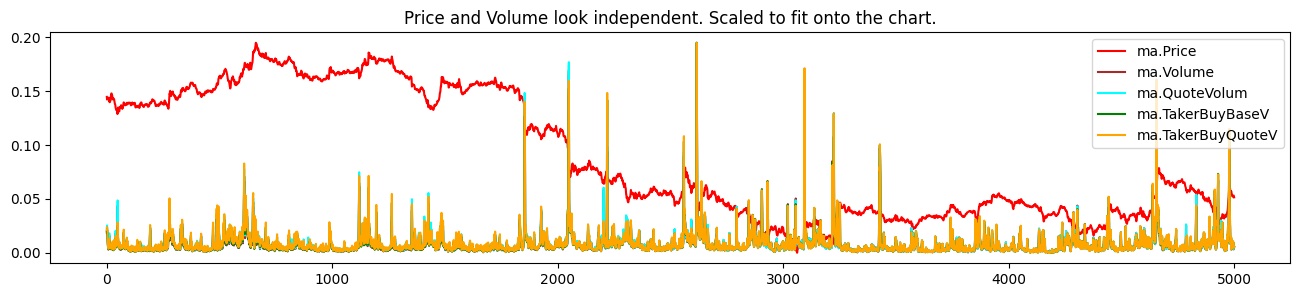

In [9]:
from Mike_NB_01 import *

market = 5
Show_Price_Volume_10(table[:, market, :], 1, 1, 5000)

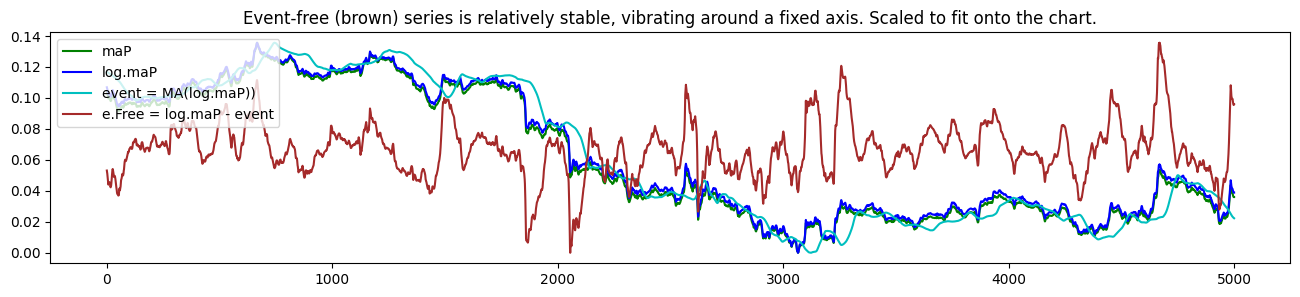

In [10]:
Event_Free_Learning_Scheme_10(table[:, market, :], 3, 30, 5000)

In [11]:
marks = table[:, :, 9] # keep it for later use

table = np.delete(table, [0, 1, 2, 5, 6, 8, 9], axis = 2) # delete Open, High, Low, qVolume, #Trades, bQVolume, Marks

from enum import Enum
class Fields(Enum):
    Close = 0       # closing price
    Volume = 1      # base volume
    bVolume = 2     # buyer base volume

table_markets = []
with open( os.path.join( Config['BinanceCandlesNumpy'], "reports-" + path + ".json"), "r") as f:
    reports = json.loads(f.read())
print(reports[:2])

markets = [ s[0: s.find(':')] for s in reports if 'Success' in s ]
assert table.shape[1] == len(markets)
print(table.shape, len(markets), markets[:2])

['ALICEUSDT: 565633, 336924 created. Success. 1-th.', 'DOTUSDT: 565633, 277039 created. Success. 2-th.']
(565633, 336, 3) 336 ['ALICEUSDT', 'DOTUSDT']


In [12]:
# restore timestamps

start = datetime( 2000+int(path[0:2]), int(path[3:5]), int(path[6:8]), int(path[9:11]), int(path[12:14]) )
start_ts = round(datetime.timestamp(start))
interval = path[ path.find('-', len(path) - 4) + 1 : ]
interval_s = round(intervalToMilliseconds(interval) / 1000)
timestamps = np.array( range(start_ts, start_ts + table.shape[0] * interval_s, interval_s), dtype=int)
assert timestamps.shape[0] == table.shape[0]
print(start_ts, interval_s, timestamps.shape, timestamps[:3])

1514764800 300 (565633,) [1514764800 1514765100 1514765400]


In [13]:
# # Find market clusters
# from sklearn.metrics import pairwise

# distances = np.zeros( (table.shape[1], table.shape[1]), dtype=float)

# # Find dependency distance
# for m in range(table.shape[1]):
#     distances[m, m] = 0.
#     for n in range(m+1, table.shape[1]):
#         mask = (marks[:, m] + marks[:, n] == 0) # marks == 0 : true full candles, marks = -1: price interpolated , marks = -2: coincodex prices
#         pm = table[mask, m, 0][np.newaxis]
#         pn = table[mask, n, 0][np.newaxis]
#         distances[m, n] = sklearn.metrics.pairwise.cosine_distances(pm, pn)
#         distances[n, m] = distances[m, n]

In [14]:
# from sklearn.cluster import OPTICS
# clustering = OPTICS(metric='precomputed', n_jobs=-1).fit(distances)
# print( clustering.labels_ )

# np.reshape(np.argwhere(clustering.labels_ == 1), -1)

# market_clusters = [ [ markets[ id ] for id in np.reshape(np.argwhere(clustering.labels_ == label), -1) ] for label in range(np.max(clustering.labels_))]
# print(market_clusters)

In [15]:
# cluster = 0
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 0. Recent prices are mediocre. Shorter history.", series, color = 'auto')

In [16]:
# cluster = 1
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 1. Vanished recently. Shorter history, Trends later", series, color = 'auto')

In [17]:
# cluster = 2
# ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
# series = [ [table[:, id, 0], markets[id] ] for id in ids ]
# PoltNormalized("Market cluster 2. Not vanished recently. Longer hostory. Trends earlier", series, color = 'auto')

In [18]:
def save_to_multiple_csv_files(data, sample_anchors, name_prefix, Nx, x_indices, Ny, y_indices, header=None, n_parts=10):
    training_dir = os.path.join("/mnt/data/Trading", "Datasets")
    os.makedirs(training_dir, exist_ok=True)
    path_format = os.path.join(training_dir, "{}_{:02d}.csv")

    filenames = []
    for file_idx, anchors in enumerate(np.array_split(sample_anchors, n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filenames.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for anchor in anchors:
                x = np.reshape(data[anchor: anchor + Nx][:, x_indices[0]][:, :, x_indices[1]], -1)
                f.write(",".join([str(col) for col in x]))
                y = np.reshape(data[anchor + Nx: anchor + Nx + Ny][:, y_indices[0]][:, :, y_indices[1]], -1)
                f.write("," + ",".join([str(col) for col in y]))
                f.write("\n")
    return filenames

In [19]:
def parse_csv_line(line, Nx, size_x, Ny, size_y):
    print(line)
    defs = [tf.constant(0.0)] * (Nx * size_x + Ny * size_y)
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack( tf.reshape(fields[: Nx * size_x], [Nx, -1] ) )    # sequence of Nx tokens, each of size_x
    y = tf.stack(fields[Nx * size_x :])
    return x, y

In [20]:
def csv_reader_dataset(filenames, Nx, size_x, Ny, size_y, n_parse_threads=5, batch_size=2, shuffle_buffer_size=10000, n_readers=5):
    dataset = tf.data.Dataset.list_files(filenames)
    # dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename), #.skip(1),
        cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(lambda x: parse_csv_line(x, Nx, size_x, Ny, size_y), num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset #.prefetch(1)

In [21]:
def get_timepoint_size(indices):
    size = 1
    for ids in indices:
        size *= len(ids)
    return size

In [22]:
# defind Data

n_times = 1000; n_markets = 2; n_fields = 2
Data = [ [ [ time * n_markets * n_fields + market * n_fields + field for field in range(n_fields) ] for market in range(n_markets) ] for time in range(n_times)]
Data = np.array(Data, dtype=float)
print(Data.shape)   # time, market, field
print(Data[:2, :, :])

(1000, 2, 2)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]


In [23]:
Nx = 2
Ny = 2
Ns = 10
BatchSize = 2

sample_anchors = range(0, Data.shape[0] - Nx - Ny, Ns)
print(Data.shape[0], len(sample_anchors), sample_anchors)

x_indices = ( (0, 1), (0, 1) )    # (market, field)
y_indices = ( (0,), (0, 1) )    # (market, field)
print(Data[0:2][:, x_indices[0]][:, :, x_indices[1]])
print(Data[2:4][:, y_indices[0]][:, :, y_indices[1]])

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
print(size_x, size_y)

1000 100 range(0, 996, 10)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
[[[ 8.  9.]]

 [[12. 13.]]]
4 2


In [24]:
filenames = save_to_multiple_csv_files(Data, sample_anchors, path + '_o', Nx, x_indices, Ny, y_indices, header=None, n_parts=10)
print(filenames)

['/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_00.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_01.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_02.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_03.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_04.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_05.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_06.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_07.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_08.csv', '/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_09.csv']


In [25]:
filename_dataset = tf.data.Dataset.list_files(filenames, shuffle=None) # no way to prevent shuffle.
print(filename_dataset.cardinality().numpy())
for element in filename_dataset:
    print(element.numpy())

10
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_01.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_06.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_04.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_03.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_00.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_09.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_07.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_08.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_05.csv'
b'/mnt/data/Trading/Datasets/18-01-01-00-00-23-05-20-20-23-5m_o_02.csv'


2023-05-25 01:40:52.185994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 01:40:52.844543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2023-05-25 01:40:52.866203: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


In [26]:
ds = tf.data.TextLineDataset(filenames[0])
for line in ds.take(20):
    print(line.numpy())

b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0,13.0'
b'40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,52.0,53.0'
b'80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,92.0,93.0'
b'120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0,132.0,133.0'
b'160.0,161.0,162.0,163.0,164.0,165.0,166.0,167.0,168.0,169.0,172.0,173.0'
b'200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,212.0,213.0'
b'240.0,241.0,242.0,243.0,244.0,245.0,246.0,247.0,248.0,249.0,252.0,253.0'
b'280.0,281.0,282.0,283.0,284.0,285.0,286.0,287.0,288.0,289.0,292.0,293.0'
b'320.0,321.0,322.0,323.0,324.0,325.0,326.0,327.0,328.0,329.0,332.0,333.0'
b'360.0,361.0,362.0,363.0,364.0,365.0,366.0,367.0,368.0,369.0,372.0,373.0'


In [27]:
n_readers = 5
dataset = filename_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filename),
    cycle_length=n_readers, num_parallel_calls=tf.data.AUTOTUNE) # no way to prevent shuffle?

for line in dataset.take(15):
    print(line.numpy())

b'800.0,801.0,802.0,803.0,804.0,805.0,806.0,807.0,808.0,809.0,812.0,813.0'
b'1200.0,1201.0,1202.0,1203.0,1204.0,1205.0,1206.0,1207.0,1208.0,1209.0,1212.0,1213.0'
b'2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2012.0,2013.0'
b'2800.0,2801.0,2802.0,2803.0,2804.0,2805.0,2806.0,2807.0,2808.0,2809.0,2812.0,2813.0'
b'3600.0,3601.0,3602.0,3603.0,3604.0,3605.0,3606.0,3607.0,3608.0,3609.0,3612.0,3613.0'
b'840.0,841.0,842.0,843.0,844.0,845.0,846.0,847.0,848.0,849.0,852.0,853.0'
b'1240.0,1241.0,1242.0,1243.0,1244.0,1245.0,1246.0,1247.0,1248.0,1249.0,1252.0,1253.0'
b'2040.0,2041.0,2042.0,2043.0,2044.0,2045.0,2046.0,2047.0,2048.0,2049.0,2052.0,2053.0'
b'2840.0,2841.0,2842.0,2843.0,2844.0,2845.0,2846.0,2847.0,2848.0,2849.0,2852.0,2853.0'
b'3640.0,3641.0,3642.0,3643.0,3644.0,3645.0,3646.0,3647.0,3648.0,3649.0,3652.0,3653.0'
b'880.0,881.0,882.0,883.0,884.0,885.0,886.0,887.0,888.0,889.0,892.0,893.0'
b'1280.0,1281.0,1282.0,1283.0,1284.0,1285.0,1286.0,1287.0,1288.0,1289.0,1292.0,

In [28]:
parse_csv_line(b'0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11.', Nx, size_x, Ny, size_y)

b'0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11.'


(<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[0., 1., 2., 3.],
        [4., 5., 6., 7.]], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 8.,  9., 10., 11.], dtype=float32)>)

In [29]:
Dataset = csv_reader_dataset(filenames, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=5)

Tensor("args_0:0", shape=(), dtype=string)


In [30]:
for element in Dataset:
    print(element)
    break

# should print: (None, Nx, size_x), (None, Ny * size_y)

(<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[2040., 2041., 2042., 2043.],
        [2044., 2045., 2046., 2047.]],

       [[2880., 2881., 2882., 2883.],
        [2884., 2885., 2886., 2887.]]], dtype=float32)>, <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2048., 2049., 2052., 2053.],
       [2888., 2889., 2892., 2893.]], dtype=float32)>)


In [31]:
print(table.shape, x_indices)
table1 = table[:, x_indices[0]]
print(table1.shape)

(565633, 336, 3) ((0, 1), (0, 1))
(565633, 2, 3)


In [32]:
# Check elements: NaN, -inf, +inf

assert (~np.isfinite(table)).any() == False

In [33]:
# Logarithmize + Smoothen


In [34]:
# Trim in time dimension

In [35]:
# Normalize (linear)

In [36]:
# Add features, including time-info

hourly = np.sin( 2 * np.pi / (60*60) * timestamps )
daily = np.sin( 2 * np.pi / (60*60*24) * timestamps )
weekly = np.sin( 2 * np.pi / (60*60*24*7) * timestamps )
yearly = np.sin( 2 * np.pi / (60*60*24*365) * timestamps )


# A normalized representation of 'timestamps'
time_of_year_sin = np.sign( 2 * np.pi / (60*60*24*365) * timestamps )
time_of_year_cos = np.cos( 2 * np.pi / (60*60*24*365) * timestamps )
time_of_week_sin = np.sign( 2 * np.pi / (60*60*24*7) * timestamps )
time_of_week_cos = np.cos( 2 * np.pi / (60*60*24*7) * timestamps )
time_of_day_sin = np.sign( 2 * np.pi / (60*60*24) * timestamps )
time_of_day_cos = np.cos( 2 * np.pi / (60*60*24) * timestamps )

print(table.shape, hourly.shape)

# table = np.insert(table, 0, hourly.reshape(1), axis=0)

(565633, 336, 3) (565633,)


In [37]:
# Define Data
enFields = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']

# dot, 1inch, btc, eth, matic, bnb, ada, sol, ltc, avax, wbtc, link, arb, ape, aave, crv, sui, op, gmx, agix, bal, comp, gmt, joe, stg
chosen_markets_x = ['DOTUSDT', '1INCHUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'LTCUSDT', 'AVAXUSDT', 'WBTCUSDT', 'LINKUSDT', ]
                  # 'ARBUSDT', 'APEUSDT', 'SUIUSDT', 'OPUSDT', 'GMXUSDT', 'AGIXUSDT', 'BALUSDT', 'COMPUSDT', 'GMTUSDT', 'JOEUSDT', 'STGUSDT']
chosen_markets_x = tuple([ markets.index(elem) for elem in chosen_markets_x ])
chosen_fields_x = ['ClosePrice'] #, 'BaseVolume']
chosen_fields_x = tuple( [ enFields.index(elem) for elem in chosen_fields_x ] )
x_indices = ( chosen_markets_x, chosen_fields_x )
print(x_indices)

chosen_markets_y = ['DOTUSDT', '1INCHUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'LTCUSDT', 'AVAXUSDT', 'WBTCUSDT', 'LINKUSDT', ]
chosen_markets_y = tuple([ markets.index(elem) for elem in chosen_markets_y ])
chosen_fields_y = ['ClosePrice']
chosen_fields_y = tuple( [ enFields.index(elem) for elem in chosen_fields_y ] )
y_indices = ( chosen_markets_y, chosen_fields_y )
print(y_indices)

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
print(size_x, size_y)

((1, 2, 3, 4, 6, 8, 11, 15, 16, 17), (0,))
((1, 2, 3, 4, 6, 8, 11, 15, 16, 17), (0,))
10 10


In [38]:
Data = table[:, :, :]

from sklearn.model_selection import train_test_split

Train, Valid = train_test_split(Data, test_size=0.30, random_state=42)
print(Train.shape, Valid.shape)

(395943, 336, 3) (169690, 336, 3)


In [39]:
Nx = 500
Ny = 5
Ns = 10
BatchSize = 64

sample_anchors_t = range(0, Train.shape[0] - Nx - Ny + 1, Ns)
print(Train.shape[0], len(sample_anchors_t), sample_anchors_t, sample_anchors_t[-1])
print(Data.shape[0], sample_anchors_t[ -1 ], sample_anchors_t[ -1 ] + Nx + Ny, sample_anchors_t[ -1 ] + Ns, sample_anchors_t[ -1 ] + Ns + Nx + Ny)

sample_anchors_v = range(0, Valid.shape[0] - Nx - Ny + 1, Ns)
print(Valid.shape[0], len(sample_anchors_v), sample_anchors_v, sample_anchors_v[-1])
print(Data.shape[0], sample_anchors_v[ -1 ], sample_anchors_v[ -1 ] + Nx + Ny, sample_anchors_v[ -1 ] + Ns, sample_anchors_v[ -1 ] + Ns + Nx + Ny)

395943 39544 range(0, 395439, 10) 395430
565633 395430 395935 395440 395945
169690 16919 range(0, 169186, 10) 169180
565633 169180 169685 169190 169695


In [40]:
nFiles = 100
n_readers = 8 #int(nFiles/2)

import os
os.system("rm /mnt/data/Trading/Datasets/*{}*".format(path))

filenames_train = save_to_multiple_csv_files(Train, sample_anchors_t, path + '_t', Nx, x_indices, Ny, y_indices, header=None, n_parts=nFiles)
filenames_valid = save_to_multiple_csv_files(Valid, sample_anchors_v, path + '_v', Nx, x_indices, Ny, y_indices, header=None, n_parts=nFiles)

Dataset_train = csv_reader_dataset(filenames_train, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=10)
Dataset_train = Dataset_train.prefetch(1)
# print(len(Dataset_train))

Dataset_valid = csv_reader_dataset(filenames_valid, Nx, size_x, Ny, size_y,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=10000, n_readers=10)
Dataset_valid = Dataset_valid.prefetch(1)
# print(len(Dataset_valid))


Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)


In [41]:
for element in Dataset_train:
    print(element)
    break

(<tf.Tensor: shape=(64, 500, 10), dtype=float32, numpy=
array([[[0.000000e+00, 0.000000e+00, 6.691310e+03, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [5.417000e+00, 4.350000e-01, 2.002927e+04, ..., 1.449000e+01,
         0.000000e+00, 6.179000e+00],
        [0.000000e+00, 0.000000e+00, 6.636970e+03, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        ...,
        [0.000000e+00, 0.000000e+00, 7.935720e+03, ..., 0.000000e+00,
         0.000000e+00, 2.060900e+00],
        [0.000000e+00, 0.000000e+00, 9.264600e+03, ..., 0.000000e+00,
         0.000000e+00, 6.166700e+00],
        [0.000000e+00, 0.000000e+00, 7.083680e+03, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00]],

       [[5.383000e+00, 4.090000e-01, 2.757197e+04, ..., 1.554000e+01,
         2.754340e+04, 6.567000e+00],
        [0.000000e+00, 0.000000e+00, 9.419010e+03, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 1.053398e+04, ..., 0.000000e

In [42]:
def mae_last_step(Y_true, Y_pred):
    return keras.mean(keras.abs(Y_pred[:, -1] - Y_true[:, -1]))

In [43]:
def huber_loss(y_true, y_pred, max_grad=1.):
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

In [44]:
from functools import partial
RegularizedLSTM = partial(keras.layers.LSTM,
                          return_sequences=True,
                          kernel_regularizer=keras.regularizers.l2(1e-4),
                          recurrent_regularizer=keras.regularizers.l2(1e-4)),
                          kernel_initializer="lecun_normal",
# model3 = keras.models.Sequential()
# model3.add(RegularizedLSTM(100, input_shape=input_shape))
# model3.add(RegularizedLSTM(100))
# model3.add(keras.layers.Dense(1))
# model3.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
#                metrics=[mae_last_step])

IndentationError: unexpected indent (1643918337.py, line 6)

In [ ]:
input_dim = size_x
units = input_dim
output_size = Ny * size_y

print(input_dim, units, output_size)

def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim), return_sequences=True, kernel_initializer="lecun_normal" )
        lstm_layer1 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True, kernel_initializer="lecun_normal" )
        lstm_layer2 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True, kernel_initializer="lecun_normal" )
        lstm_layer3 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True, kernel_initializer="lecun_normal" )
        lstm_layer4 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True, kernel_initializer="lecun_normal" )
        lstm_layer5 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True, kernel_initializer="lecun_normal" )
        lstm_layer6 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True, kernel_initializer="lecun_normal" )
        lstm_layer7 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True, kernel_initializer="lecun_normal" )
        lstm_layer8 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True, kernel_initializer="lecun_normal" )
        lstm_layer9 = keras.layers.LSTM(units, input_shape=(None, units) )

    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(None, input_dim), return_sequences=True)

    # with mirrored_strategy.scope():
    model = keras.models.Sequential(
        [
            lstm_layer,
            lstm_layer1,
            lstm_layer2,
            lstm_layer3,
            lstm_layer4,
            lstm_layer5,
            lstm_layer6,
            lstm_layer7,
            lstm_layer8,
            lstm_layer9,
            keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal"),
            keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal"),
            keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal"),
            keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal"),
            keras.layers.Dense(output_size, activation="selu", kernel_initializer="lecun_normal"),
        ]
    )

    model.compile(
        loss=keras.losses.MSE,
        optimizer=keras.optimizers.Adam(
            learning_rate=0.03,  # def lr = 0.001
            beta_1=0.9, 
            beta_2=0.999, 
            epsilon=1e-07
        ),
        # metrics=keras.metrics.MSE,
    )

    return model

In [ ]:
model = build_model(allow_cudnn_kernel=True)
# model.summary()
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# options = tf.data.Options()
# options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
# train_data = Dataset_train.with_options(options)
# val_data = Dataset_valid.with_options(options)

history = model.fit(Dataset_train, validation_data=Dataset_valid, epochs=1000)

In [ ]:
def plot_history(history, loss="loss"):
    train_losses = history.history[loss]
    valid_losses = history.history["val_" + loss]
    n_epochs = len(history.epoch)
    minloss = np.min(valid_losses)
    
    plt.plot(train_losses, color="b", label="Train")
    plt.plot(valid_losses, color="r", label="Validation")
    plt.plot([0, n_epochs], [minloss, minloss], "k--",
             label="Min val: {:.2f}".format(minloss))
    plt.axis([0, n_epochs, 0, 20])
    plt.legend()
    plt.show()

In [ ]:
pd.DataFrame(history.history).plot()
plt.axis([0, 19, 0, 1])
plt.show()

In [ ]:
# history_2= model.fit(Dataset_train, validation_data=Dataset_valid, epochs=10, initial epoch=history_1.epoch(-1) )

In [ ]:
plot_history(history2, loss="mae_last_step")